## Test with a sliding window of 30 minutes and a 5 minute overlap 

### Despike filter was set at 50, as in the test 10 case

Results are much worse than in the 1 minute overlap case - suggests that the more data we have, the better this
works, or theres something wrong with the way we handle the overlaps

In [1]:
import pandas as pd
import obspy as op
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import glob
%matplotlib inline

In [22]:
all_data = pd.read_csv("Fnames_soilM_temp.csv")
lineCSN = all_data[all_data['Line'] == "LineCSN"]

#Extract just the soil moisture time series corresponding to probe M3_20
lineCSN_M3 = lineCSN[['file_name','DateTime','M3_20_Avg_interp','Temphigh_interp']]
lineCSN_M3.reset_index(drop=True,inplace=True)
lineCSN_M3.assign(DateTime = pd.to_datetime(lineCSN_M3['DateTime']))
lineCSN_M3.set_index('DateTime',inplace=True)
#Generate linking column
lineCSN_M3 = lineCSN_M3.assign(file_name=lineCSN_M3['file_name'].apply(lambda x: x[2:]))

In [23]:
feature_files = glob.glob('/home/rmartinshort/Documents/Berkeley/Fiber/data_test/Soil_moisture_predict/rms_sliding_30_5_50/*.csv')
feature_dfs = []
for csv_file in feature_files:
    fname = csv_file.split('/')[-1].split('.')[0][:-19]
    print(fname)
    df = pd.read_csv(csv_file)
    df.name = fname
    feature_dfs.append(df)

fft_energy_rms_fc
variance_rms_fc
root_mean_square_rms_fc
mean_change_rms_fc
interquartile_range_rms_fc
minimum_rms_fc
mean_abs_change_rms_fc
abs_energy_rms_fc
maximum_rms_fc
mean_rms_fc
skewness_rms_fc
x_crossing_m_rms_fc
peak_welch_rms_fc
kurtosis_rms_fc
median_rms_fc
cid_ce_rms_fc


In [24]:
lineCSN_M3['TTime'] = lineCSN_M3.index
stime = lineCSN_M3.index[0]
print(op.UTCDateTime(stime))
lineCSN_M3 = lineCSN_M3.assign(tsince_start=lineCSN_M3['TTime'].apply(lambda x: op.UTCDateTime(x) - op.UTCDateTime(stime)))

2016-08-05T18:07:38.000000Z


In [25]:
f_soilM = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['M3_20_Avg_interp'].values)
f_temp = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['Temphigh_interp'].values)

In [26]:
def extract_mean_over_channels(indf,channels_to_drop):
    
    '''Takes an input dataframe, calculates the mean over columns that are not in the list 
    "channels_to_drop". Returns mean dataframe
    '''
    
    newcolname = "mean_%s" %indf.name
    opdf = indf[['time']]
    
    ### This requires all data to be non NAN in that window, otherwise a NAN is reported
    opdf = opdf.assign(mean_col = indf.drop(channels_to_drop,axis=1).mean(axis=1,skipna=False))
    opdf.columns = ['time',newcolname]
    
    return opdf

In [27]:
feature_dfs[0].head()

,channel_80,channel_81,channel_82,channel_83,channel_84,channel_85,channel_86,channel_87,channel_88,channel_89,time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:53:01.281914Z
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:58:01.282279Z
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T19:03:01.282279Z
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T19:08:01.282279Z
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T19:13:01.282279Z


# Test 1

### Same as test 1 of REFREG_test10 - mean over channels 84-86

In [28]:
channels_to_drop = ['time','channel_80','channel_81','channel_82','channel_83',
                    'channel_87','channel_88','channel_89']

#channels_to_drop = ['time']

print(len(feature_dfs[0]))
indf = extract_mean_over_channels(feature_dfs[0],channels_to_drop)

12905


In [29]:
for feature_df in feature_dfs[1:]:
    
    mean_feature = extract_mean_over_channels(feature_df,channels_to_drop)
    merged_df = pd.merge(indf,mean_feature,on='time')
    indf = merged_df

In [30]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))  
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))

In [31]:
print(len(merged_df))
cleaned_df = merged_df.dropna()
len(cleaned_df)

12905


1806

Note much smaller number of datapoints than in the 1 minute overlap case

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [33]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,min_samples_split=2,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [34]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.01767331 0.01845708 0.02045586 0.03720421 0.0547873  0.06157003
 0.03001605 0.01678522 0.05713867 0.09990592 0.08079542 0.16367066
 0.08329966 0.09215759 0.12790602 0.03817698]
0.4568647074999109


In [35]:
regr.score(X_test,y_test)

0.4954356144608079

In [36]:
regr_pred = regr.predict(X_test)

outliers_y = []
outliers_x = []
X_test_indices_bad = []
X_test_indices_good = []
i = 0
for element in zip(regr_pred,y_test):
    if abs(element[0]-element[1]) > 0.015:
        outliers_x.append(element[0])
        outliers_y.append(element[1])
        X_test_indices_bad.append(X_test.index[i])
    else:
        X_test_indices_good.append(X_test.index[i])
    i += 1

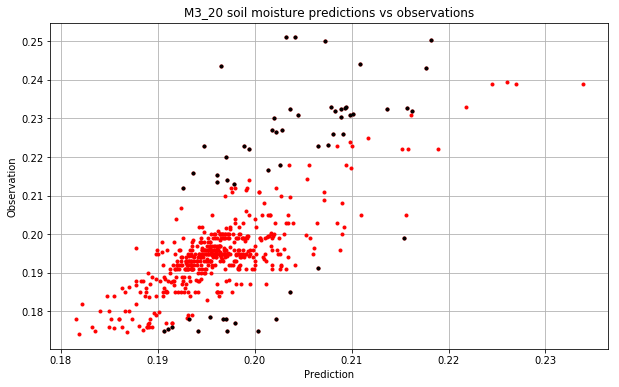

In [37]:
plt.figure(figsize=(10,6))
plt.title('M3_20 soil moisture predictions vs observations')
plt.plot(regr_pred,y_test,'r.')
plt.plot(outliers_x,outliers_y,'k.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

In [38]:
outliers = cleaned_df.loc[X_test_indices_bad]
inliers = cleaned_df.loc[X_test_indices_good]
outlier_x = np.array(outliers['tsince_start'])
outlier_y = np.array(outliers['M3_20_Avg_interp'])
inlier_x = np.array(inliers['tsince_start'])
inlier_y = np.array(inliers['M3_20_Avg_interp'])
reg_x = np.array(cleaned_df['tsince_start'])
reg_y = np.array(cleaned_df['M3_20_Avg_interp'])

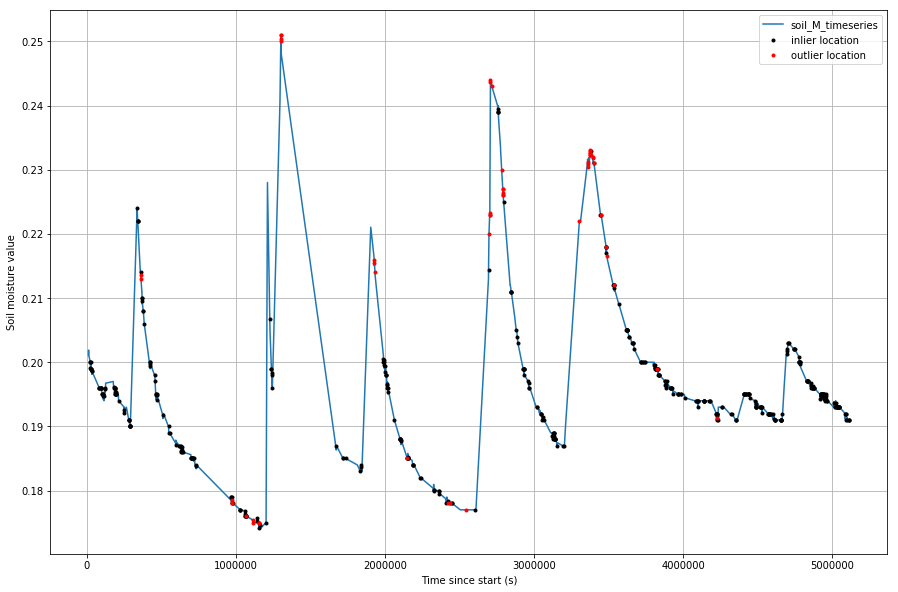

In [39]:
plt.figure(figsize=(15,10))
plt.plot(reg_x,reg_y,label='soil_M_timeseries')
plt.plot(inlier_x,inlier_y,'k.',label='inlier location')
plt.plot(outlier_x,outlier_y,'r.',label='outlier location')
plt.xlabel('Time since start (s)')
plt.ylabel('Soil moisture value')
plt.legend()
plt.grid()

## Temperature data

In [44]:
y = cleaned_df['Temphigh_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,min_samples_split=2,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [45]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.0112647  0.0105046  0.01275383 0.02485783 0.05240059 0.04710608
 0.03009063 0.01114209 0.06430694 0.09089255 0.04667064 0.29723881
 0.13286809 0.05850168 0.08592462 0.02347632]
0.6233172982053954


In [46]:
regr_pred = regr.predict(X_test)
outliers_y = []
outliers_x = []
X_test_indices = []
i = 0
for element in zip(regr_pred,y_test):
    if abs(element[0]-element[1]) > 4:
        outliers_x.append(element[0])
        outliers_y.append(element[1])
        X_test_indices.append(X_test.index[i])
    i += 1

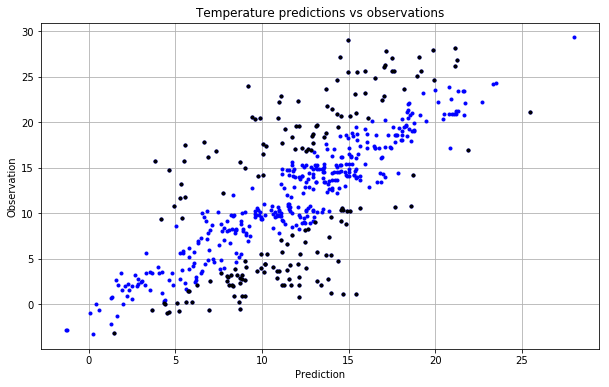

In [47]:
plt.figure(figsize=(10,6))
plt.title('Temperature predictions vs observations')
plt.plot(regr_pred,y_test,'b.')
plt.plot(outliers_x,outliers_y,'k.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('temperature_prediction_sliding_window.png')

# Test 2

## Extracting features from just channel 85


In [48]:
channels_to_drop = ['time','channel_80','channel_81','channel_82','channel_83','channel_84','channel_86',
                    'channel_87','channel_88','channel_89']
indf = extract_mean_over_channels(feature_dfs[0],channels_to_drop)

for feature_df in feature_dfs[1:]:
    
    mean_feature = extract_mean_over_channels(feature_df,channels_to_drop)
    merged_df = pd.merge(indf,mean_feature,on='time')
    indf = merged_df
    print(len(indf))

12905
12905
12905
12905
12905
12905
12905
12905
12905
12905
12905
12905
12905
12905
12905


In [49]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))  
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))

In [50]:
print(len(merged_df))
cleaned_df = merged_df.dropna()
len(cleaned_df)

12905


2235

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [52]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=500,min_samples_leaf=1,min_samples_split=2,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [53]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.01774086 0.0162919  0.01710614 0.03791111 0.06094989 0.07689472
 0.03033478 0.0168052  0.07049832 0.10116231 0.08973092 0.15737772
 0.09006755 0.10379291 0.08142115 0.03191451]
0.4933175479049674


In [54]:
regr.score(X_test,y_test)

0.43920347825834183

In [55]:
regr_pred = regr.predict(X_test)

outliers_y = []
outliers_x = []
X_test_indices_bad = []
X_test_indices_good = []
i = 0
for element in zip(regr_pred,y_test):
    if abs(element[0]-element[1]) > 0.015:
        outliers_x.append(element[0])
        outliers_y.append(element[1])
        X_test_indices_bad.append(X_test.index[i])
    else:
        X_test_indices_good.append(X_test.index[i])
    i += 1

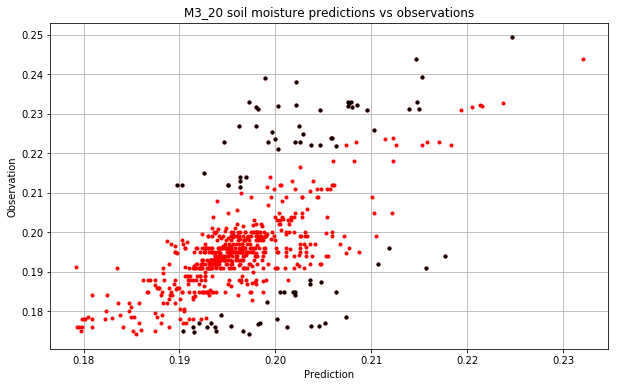

In [56]:
plt.figure(figsize=(10,6))
plt.title('M3_20 soil moisture predictions vs observations')
plt.plot(regr_pred,y_test,'r.')
plt.plot(outliers_x,outliers_y,'k.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

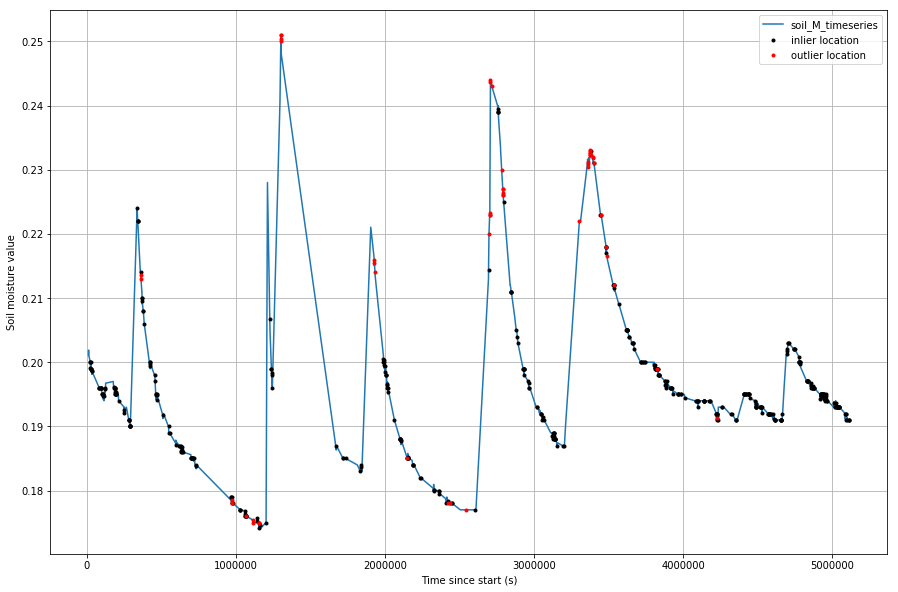

In [57]:
plt.figure(figsize=(15,10))
plt.plot(reg_x,reg_y,label='soil_M_timeseries')
plt.plot(inlier_x,inlier_y,'k.',label='inlier location')
plt.plot(outlier_x,outlier_y,'r.',label='outlier location')
plt.xlabel('Time since start (s)')
plt.ylabel('Soil moisture value')
plt.legend()
plt.grid()